# Analysing Data with Gensim

Recall that in the chapter of SciKit-Learn we dealt with the problem: Given a random card. Give examples of similar cards. We decided similarity by pre-assigned attributes and general card stats. Now we want to consider the in-game text itself. First, we present a trivial way by selecting only cards with the same text or subtext. Second, we deal with a word or text embedding into a vector space (Word2Vec, Doc2Vec). Then one can check similar texts by comparing the angle of the embedded vectors.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import requests
import re

In [2]:
# Importing the Data
columns = ['id','name','text','manaCost','manaValue','colorIdentity','colors','convertedManaCost','type','types','loyalty','power','toughness','keywords',
    'edhrecRank','life','defense','scryfallId','scryfallIllustrationId','scryfallOracleId','relatedCards']

dtype = {'id': 'int64','name': str,'text': str,'manaCost': str,'manaValue': float,'colorIdentity': str,'colors': str,
        'convertedManaCost': float,'type': str,'types': str,'loyalty': 'object','power': 'object','toughness': 'object',
        'keywords': str,'edhrecRank': 'object','life': 'object','defense': 'object','scryfallId': str,'scryfallIllustrationId': str,
        'scryfallOracleId': str,'relatedCards': str }

db = pd.read_csv('../data/mtg_cards_data/AllPrintingsCSVFiles/cards.csv',usecols = columns, dtype = dtype)

In [3]:
# Setting up the DB for our problem
# For simplicity, we restrict to only commander cards (in general, that are legendary creatures)

db = db.groupby('name',as_index=False).first()
db_cmd = db[db['type'].str.contains(r'^(?=.*Legendary)(?=.*Creature)', case=False)]
db_cmd = db_cmd.drop(columns=['life','loyalty','defense']).sort_values('edhrecRank',ascending=True)
db_cmd['Text'] = db_cmd.apply(lambda x: re.sub(r'[\(].*[\)]', '',str(x['text']).replace(x['name'], 'this card').replace(x['name'].split(',')[0], 'this card')) if (x['text']) else x['text'],axis=1)

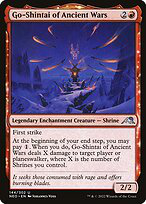

In [4]:
# Generating a rdm cmd card

card = db_cmd.iloc[np.random.randint(0,len(db_cmd)),:]
card_im = Image.open(requests.get('https://api.scryfall.com/cards/' + card.scryfallId + '/?format=image&version=small',stream=True).raw)
display(card_im)

Similar cards with First strike are:


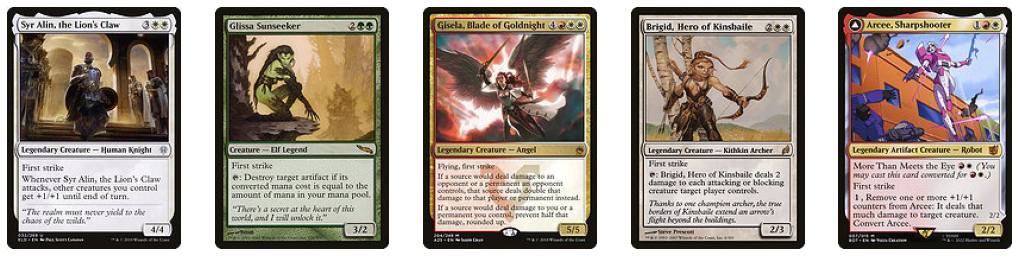

In [5]:
# Similar cards dep. on keywords
if (card.keywords):
    for word in card.keywords.split(','):
        print('Similar cards with',word,'are:')
        plt.figure(figsize=(18,6))
        for i,scryfallId in enumerate(db_cmd[(db_cmd['keywords'].str.contains(word, na=False))& (db_cmd['scryfallId'] != card.scryfallId)].head()['scryfallId']):
            im = Image.open(requests.get('https://api.scryfall.com/cards/' + scryfallId + '/?format=image&version=small', stream=True).raw)
            ax = plt.subplot(1,5,i+1)
            ax.axis('off')
            plt.imshow(im)
        plt.show()

In [6]:
# Classification of abilities of the card
import re
i = 0
for ab in card.Text.split('\n'):
    ab = re.sub(r'[\(].*[\)]', '', ab) #rmv explaining text
    if(ab.count(':') > 0):
        i = i+1
        print('Activated Ability',i,': \n',ab,'\n')
    elif(len(re.findall('when |whenever |at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ', ab, flags=re.IGNORECASE))):
        i = i+1
        print('Triggered Ability',i,': \n',ab,'\n')
    else:
        if(len([word for word in ab.split(',') if re.findall(r'\w+',word)[0] in card.keywords])):
            i = i+1
            print('Keywords Ability',i,': \n',ab,'\n')
        else:
            i = i+1
            print('Static Ability',i,': \n',ab,'\n')

Keywords Ability 1 : 
 First strike 

Triggered Ability 2 : 
 At the beginning of your end step, you may pay {1}. When you do, this card deals X damage to target player or planeswalker, where X is the number of Shrines you control. 



In [7]:
# Especially important are Triggert Abilities, as they containt more than just an effect.

tr_ab = []
triggers = []
if_triggers = []
effects = []

for ab in card.Text.split('\n'):
    if(len(re.findall('when |whenever |at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ', ab, flags=re.IGNORECASE))):
        tr_ab = tr_ab + [ab]

for ab in tr_ab:
    for ab_sen in ab.split('.'):
        for ab_subsen in ab_sen.split(','):
            if(len(re.findall('^when |^whenever |^at |[^a-zA-Z]when |[^a-zA-Z]whenever |[^a-zA-Z]at ', ab_subsen, flags=re.IGNORECASE))):
                triggers = triggers + [ab_subsen]
                print('Trigger:', ab_subsen)
            elif(len(re.findall('^if |[^a-zA-Z]if ',ab_subsen,flags=re.IGNORECASE))):
                if_triggers = if_triggers + [ab_subsen]
                print('If Cond:', ab_subsen)
            else:
                if(ab_subsen):
                    effects = effects + [ab_subsen]
                    print('Effect:', ab_subsen)
    print()

Trigger: At the beginning of your end step
Effect:  you may pay {1}
Trigger:  When you do
Effect:  this card deals X damage to target player or planeswalker
Effect:  where X is the number of Shrines you control



Similar cards with trigger: ' At the beginning of your end step ' are :


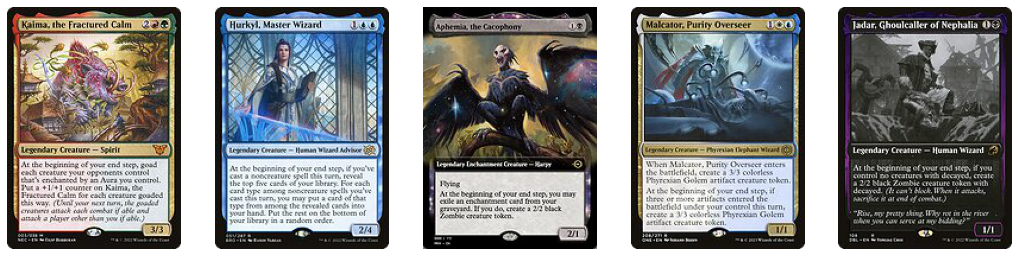

Similar cards with trigger: '  When you do ' are :


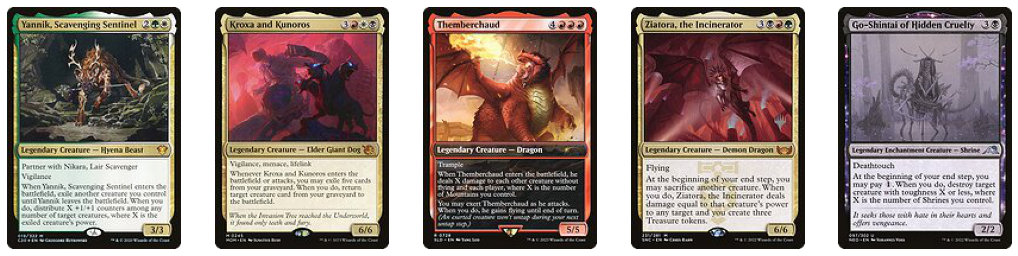

Similar cards with effect: '  you may pay {1} ' are :


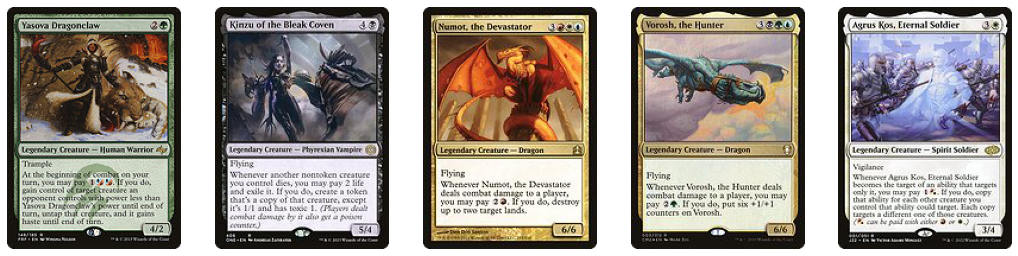

Similar cards with effect: '  this card deals X damage to target player or planeswalker ' are :


<Figure size 1296x432 with 0 Axes>

Similar cards with effect: '  where X is the number of Shrines you control ' are :


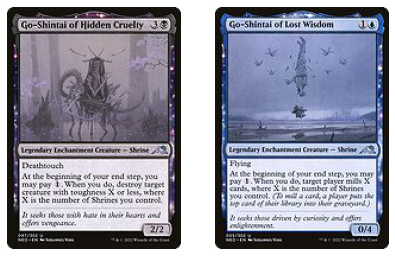

In [8]:
#similar cards wrt triggered abilities

for trigger in triggers:
    print('Similar cards with trigger: \'',trigger,'\' are :')
    plt.figure(figsize=(18,6))
    for i,scryfallId in enumerate(db_cmd[(db_cmd['Text'].str.lower().str.contains(trigger.lower(), na=False))& (db_cmd['scryfallId'] != card.scryfallId)].head()['scryfallId']):
        im = Image.open(requests.get('https://api.scryfall.com/cards/' + scryfallId + '/?format=image&version=small', stream=True).raw)
        ax = plt.subplot(1,5,i+1)
        ax.axis('off')
        plt.imshow(im)
    plt.show()
    
for trigger in if_triggers:
    print('Similar cards with if-trigger: \'',trigger,'\' are :')
    plt.figure(figsize=(18,6))
    for i,scryfallId in enumerate(db_cmd[(db_cmd['Text'].str.lower().str.contains(trigger.lower(), na=False))& (db_cmd['scryfallId'] != card.scryfallId)].head()['scryfallId']):
        im = Image.open(requests.get('https://api.scryfall.com/cards/' + scryfallId + '/?format=image&version=small', stream=True).raw)
        ax = plt.subplot(1,5,i+1)
        ax.axis('off')
        plt.imshow(im)
    plt.show()
    
for effect in effects:
    print('Similar cards with effect: \'',effect,'\' are :')
    plt.figure(figsize=(18,6))
    for i,scryfallId in enumerate(db_cmd[(db_cmd['Text'].str.lower().str.contains(effect.lower(), na=False))& (db_cmd['scryfallId'] != card.scryfallId)].head()['scryfallId']):
        im = Image.open(requests.get('https://api.scryfall.com/cards/' + scryfallId + '/?format=image&version=small', stream=True).raw)
        ax = plt.subplot(1,5,i+1)
        ax.axis('off')
        plt.imshow(im)
    plt.show()

## Card Effects are unique

Despite the fact that triggers are often similar, card effects are not. Thus to search cards with the same effect is often unlikely to succeed. One way to analyse texts is through embedding into a vector space.

In [9]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [10]:
#training set

cd_text_abb = []
for doc in list(db_cmd['Text']):
    if (doc):
        cd_text_abb = cd_text_abb + doc.split('\n')

cd_text = [' '.join(' '.join(' '.join(' '.join(doc.split('.')).split(',')).split('(')).split(')')).split() for doc in cd_text_abb]
documents = [TaggedDocument(doc,[i]) for i,doc in enumerate(cd_text)]

In [11]:
# doc2vec (self trained)

model_d2v = Doc2Vec(documents,vector_size=300,window=5,min_count=1,workers=4)

In [15]:
# test on samples

sen1 = cd_text[np.random.randint(0,len(cd_text))]
sen2 = cd_text[np.random.randint(0,len(cd_text))]

print(sen1)
print(sen2)
print('Similarity by doc2vec (self trained):', model_d2v.wv.n_similarity(sen1,sen2))

['{2}{R}:', 'this', 'card', 'deals', '3', 'damage', 'to', 'target', 'creature']
['When', 'this', 'card', 'dies', 'you', 'lose', '2', 'life']
Similarity by doc2vec (self trained): 0.8448138


In [16]:
# test on samples (cont.)

db = pd.DataFrame({'text': cd_text})
db['sim_d2v'] = db.apply(lambda x: model_d2v.wv.n_similarity(sen1,x['text'])if (x['text']) else 0,axis=1)

In [17]:
# test on samples (cont.)
print('Similar texts as:', sen1)
print()
print('Top five sim. card texts by doc2vec :')
print(list(db.sort_values('sim_d2v',ascending = False)['text'].head(5)))
print()

Similar texts as: ['{2}{R}:', 'this', 'card', 'deals', '3', 'damage', 'to', 'target', 'creature']

Top five sim. card texts by doc2vec :
[['{2}{R}:', 'this', 'card', 'deals', '3', 'damage', 'to', 'target', 'creature'], ['{3}{R}:', 'this', 'card', 'deals', '2', 'damage', 'to', 'target', 'creature'], ['{T}:', 'this', 'card', 'deals', '2', 'damage', 'to', 'target', 'creature'], ['•', 'this', 'card', 'deals', '1', 'damage', 'to', 'target', 'creature'], ['•', 'this', 'card', 'deals', '3', 'damage', 'to', 'target', 'player', 'or', 'planeswalker']]

